In [2]:
import pandas as pd
import numpy as np
import phate
import scprep
import magic

import matplotlib.pyplot as plt
import seaborn as sns

import time, os, tarfile



## Identifying branch-specific gene trends in the Treutlein fibroblast data

In this exercise, we will Slingshot on a dataset of 392 cells generated from trans-differentiating fibroblasts from [Treutlein et al. _Nature_. 2016](http://doi.org/10.1038/nature18323). This data was already preprocessed and downloaded from the [Dynverse quickstart tutorial](https://dynverse.org/users/2-quick_start/).

Briefly, a variety of transcription factors were overexpressed in Mouse Embryonic Fibroblasts (MEFs) to induce neuronal differentiation. Cells were sampled at several intervals over 22 days of differentation and sequenced using the Fluidigm C1 system and the SMART-seq protocol.

Once we have identified the three branches in this dataset, we are going to use DREMI to identify branch-specific trends in gene expression.

## Loading and visualizing the data

#### Download data from Google Drive

In [3]:
data = pd.read_pickle('/home/dan/burkhardt/Peer_2015_EMT_data.pkl.gz')

In [16]:
phate_op = phate.PHATE()

In [27]:
data_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 7102 cells and 14737 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.69 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 9.44 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.90 seconds.
    Calculating KMeans...
    Calculated KMeans in 17.53 seconds.
  Calculated landmark operator in 19.72 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 0.86 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 107.53 seconds.
Calculated PHATE in 137.93 seconds.


In [28]:
phate_clusters = phate.cluster.kmeans(n_clusters=7, phate_op=phate_op)

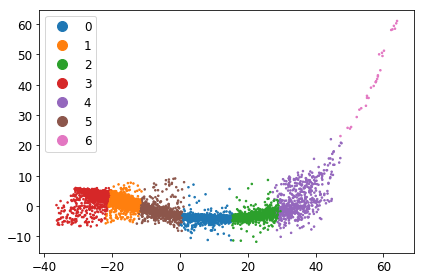

In [29]:
scprep.plot.scatter2d(data_phate, c=phate_clusters)

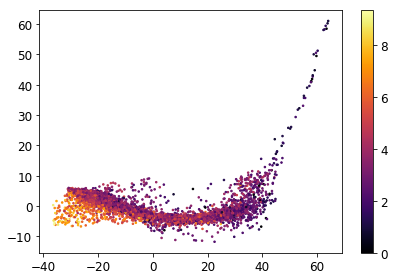

In [30]:
scprep.plot.scatter2d(data_phate, c=data['VIM'])

In [24]:
data_fil = data[good_cells]

In [32]:
better_cells = ~np.isin(phate_clusters, [6])

In [33]:
data = data[better_cells]

In [34]:
data.to_pickle('/home/dan/burkhardt/Peer_2015_EMT_data.filtered.pkl.gz')

### MAGIC

In [42]:
data_magic = magic.MAGIC(t=4).fit_transform(data)

Calculating MAGIC...
  Running MAGIC on 7072 cells and 14737 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.96 seconds.
    Calculating affinities...
    Calculated affinities in 9.80 seconds.
  Calculated graph and diffusion operator in 24.32 seconds.
  Calculating imputation...
  Calculated imputation in 1.71 seconds.
Calculated MAGIC in 27.99 seconds.


### Ordering genes by VIM

In [37]:
from joblib import Parallel, delayed
dremi_scores = Parallel(n_jobs=28)(delayed(scprep.stats.knnDREMI)(data_magic['VIM'], data_magic[g], n_jobs=1) for g in data_magic.columns)


In [9]:
dremi = np.zeros(data_magic.shape[1])
for i, gene in enumerate(data_magic.columns):
    dremi[i] = scprep.stats.knnDREMI(data_magic['VIM'], data_magic[gene])
    

In [44]:
top_genes = np.argsort(dremi_scores)[::-1][1:]

In [46]:
top_genes[:50]

array([ 5687,  9646,  3740,  8867,  8117,  3136,  5711,  1546, 13871,
         979, 13261, 11985,  6042,  8601, 11533,  5092, 13424,  2618,
        5475, 13394,  1664,  8676,  2372, 12541, 14413,  7683,  7052,
        5537,  1810,  8710,  9976, 12104,  1328,   695,  4148,  6478,
        1838, 13307,  9863,  1126,   833, 14621,  5407, 14194,  8998,
        6749,  7454,  9546,  9113, 11683])

0        102
1       2960
2       2584
3       2476
4       5911
        ... 
7518    5461
7519    3604
7520    3982
7521      41
7522    5398
Name: VIM, Length: 7072, dtype: int64

In [50]:
data_magic.sort_values('VIM').iloc[:, top_genes[:50]]

,KCTD1,RP11-114H23.3,ENTPD2,PSORS1C1,PDZD7,DENND5A,KDF1,C1QTNF6,VPS37B,ARSI,...,AQP3,ZNF747,IL18,ZDHHC1,QKI,MINK1,NFIB,ROGDI,RAET1G,SIRT6
105,0.352182,0.008288,0.102890,0.044810,0.031310,0.044896,0.159698,0.092755,0.501930,0.086379,...,0.147677,0.056692,0.210520,0.026140,0.395932,0.144321,0.635323,0.046074,0.019091,0.117979
3099,0.324361,0.007056,0.109147,0.050983,0.031706,0.050773,0.167538,0.092816,0.453923,0.069379,...,0.127554,0.044109,0.215155,0.022812,0.454699,0.146366,0.612658,0.049019,0.017496,0.121843
2703,0.335626,0.006873,0.106565,0.048683,0.031788,0.051685,0.166842,0.093019,0.461759,0.072381,...,0.127310,0.045779,0.213012,0.022841,0.458634,0.148983,0.647198,0.049734,0.018249,0.122195
2591,0.346905,0.007592,0.099490,0.044238,0.030666,0.039134,0.153566,0.091789,0.491677,0.089145,...,0.145118,0.056703,0.211683,0.026005,0.370168,0.144117,0.625588,0.046109,0.020033,0.115220
6261,0.341874,0.007498,0.098369,0.044417,0.030065,0.037196,0.151855,0.091239,0.481212,0.086263,...,0.143100,0.056223,0.210454,0.025237,0.360430,0.141561,0.623471,0.044163,0.019307,0.113167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780,0.188963,0.001312,0.012580,0.017823,0.008054,0.135355,0.079982,0.021711,0.258251,0.040454,...,0.012552,0.028655,0.063042,0.005501,0.732793,0.074000,1.028661,0.017166,-0.000403,0.052046
3775,0.180439,0.001312,0.011323,0.018765,0.007532,0.135767,0.079758,0.020674,0.252074,0.040910,...,0.008645,0.027888,0.062287,0.004930,0.731197,0.070814,1.027896,0.016415,-0.000063,0.049907
4187,0.183419,0.001089,0.010611,0.017389,0.007769,0.135109,0.077583,0.020915,0.251332,0.039356,...,0.009919,0.027704,0.058896,0.004578,0.739101,0.070434,1.024711,0.016194,-0.000934,0.049366
42,0.175184,0.001006,0.008779,0.017572,0.007125,0.140176,0.075518,0.019412,0.242048,0.038330,...,0.006090,0.027304,0.059045,0.004296,0.740661,0.068129,1.029730,0.015279,-0.000878,0.048035


In [74]:
expression = data_magic.sort_values('VIM').iloc[:, top_genes[:500]]

In [53]:
import sklearn

In [75]:
expression  = sklearn.preprocessing.StandardScaler().fit_transform(expression)

In [63]:
vim = data_magic.sort_values('VIM')['VIM']

In [66]:
vim = sklearn.preprocessing.StandardScaler().fit_transform(vim.values.reshape(-1,1))

In [70]:
vim_colors = plt.cm.RdBu_r(vim.flatten())

In [71]:
vim_colors

array([[0.01960784, 0.18823529, 0.38039216, 1.        ],
       [0.01960784, 0.18823529, 0.38039216, 1.        ],
       [0.01960784, 0.18823529, 0.38039216, 1.        ],
       ...,
       [0.40392157, 0.        , 0.12156863, 1.        ],
       [0.40392157, 0.        , 0.12156863, 1.        ],
       [0.40392157, 0.        , 0.12156863, 1.        ]])

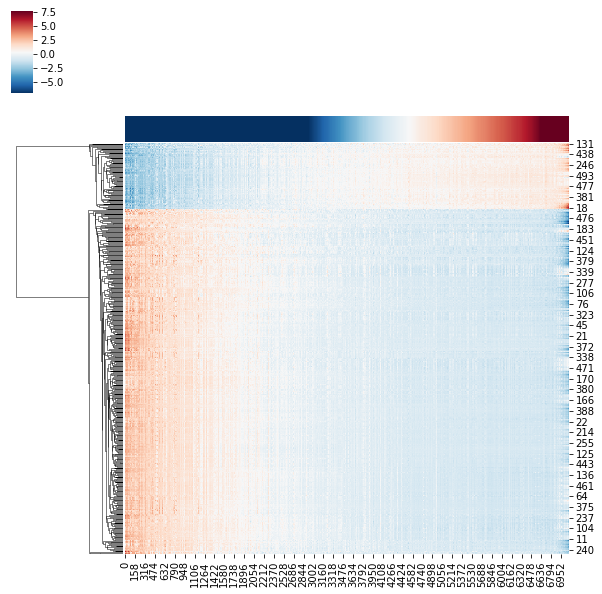

In [76]:
sns.clustermap(expression.T, col_colors=vim_colors, cmap='RdBu_r', col_cluster=False)

In [78]:
clusters = sklearn.cluster.KMeans(22).fit_predict(data_magic.sort_values('VIM').iloc[:, top_genes[:10000]].T)

/usr/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


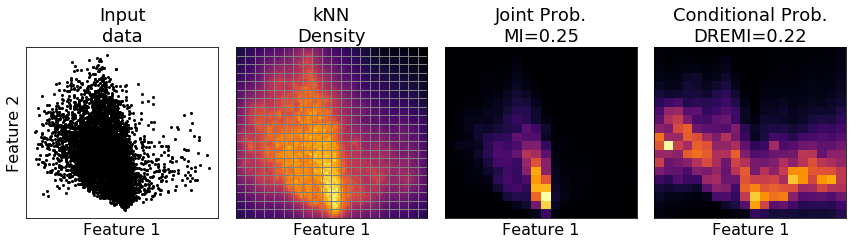

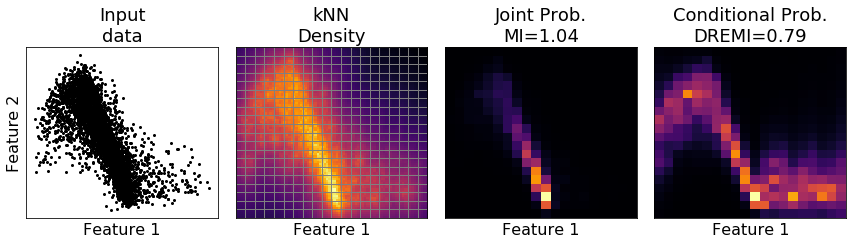

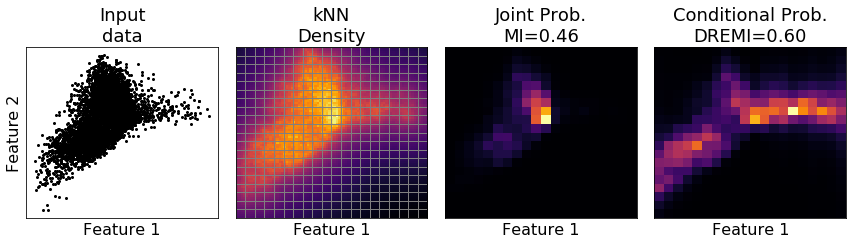

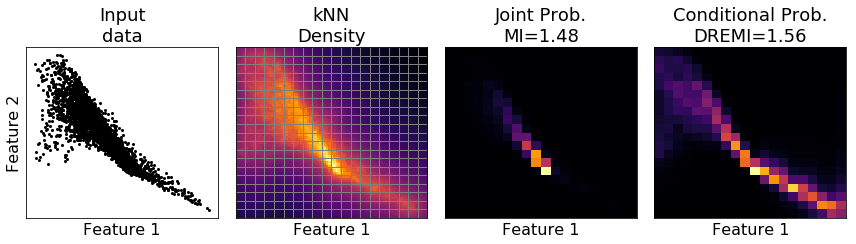

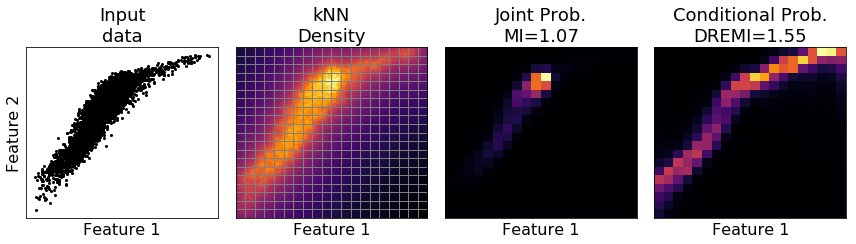

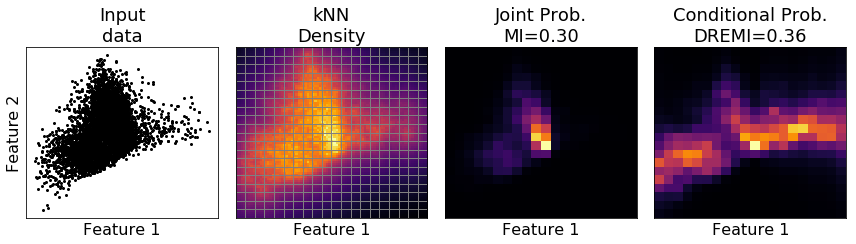

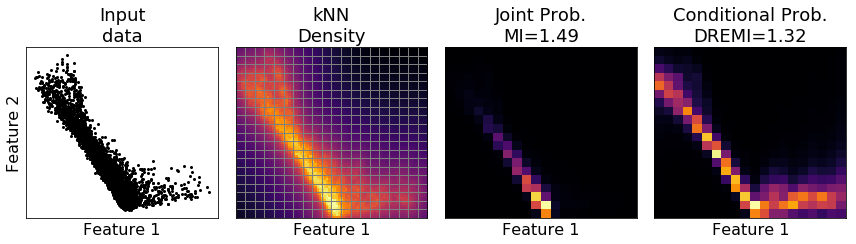

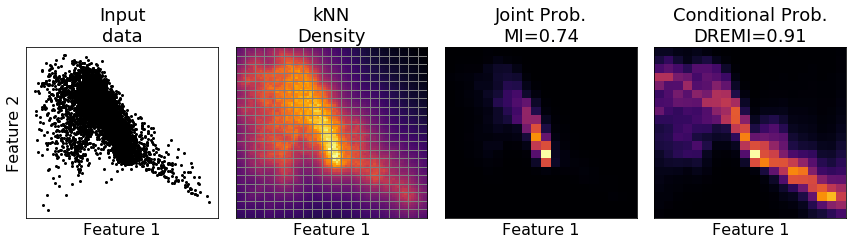

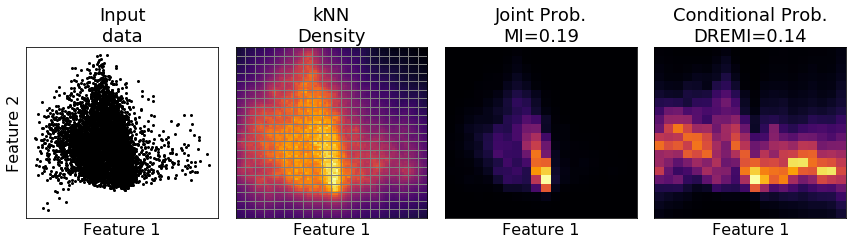

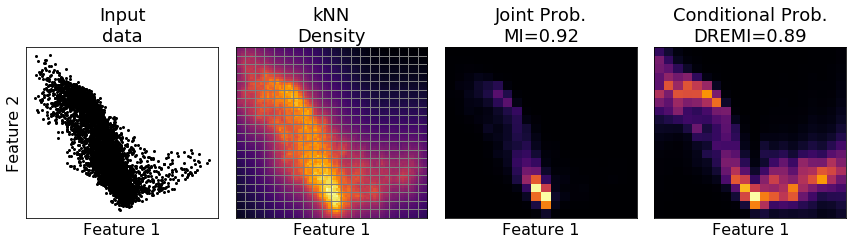

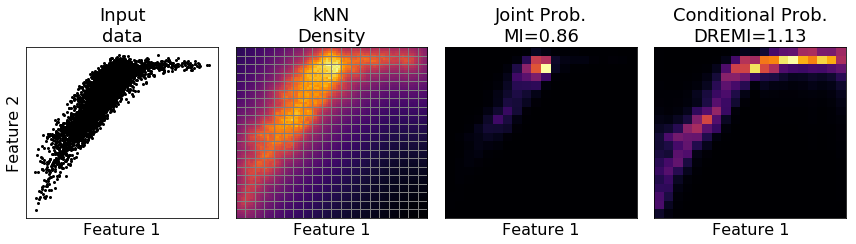

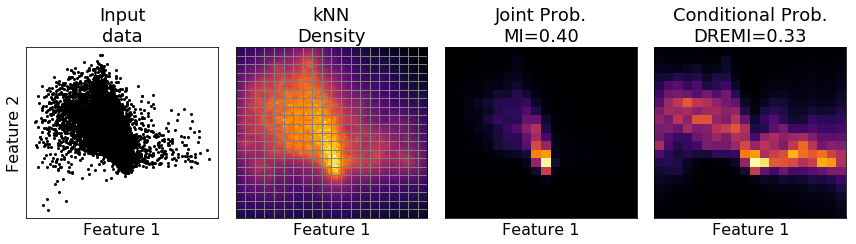

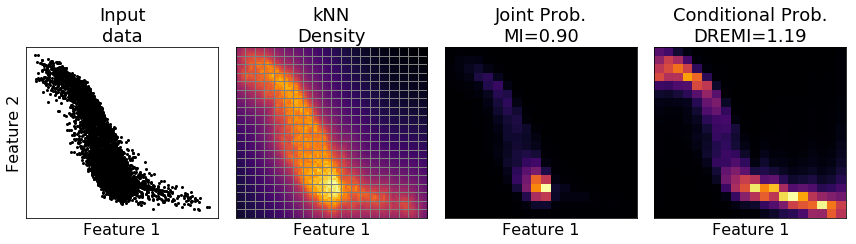

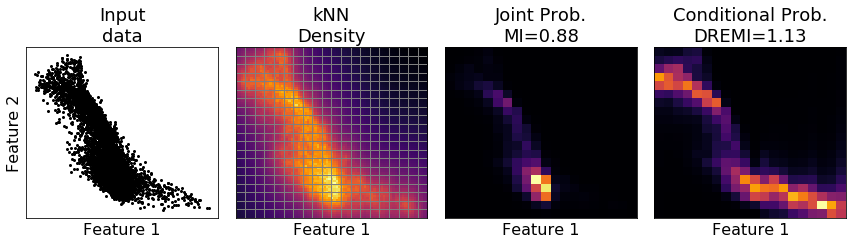

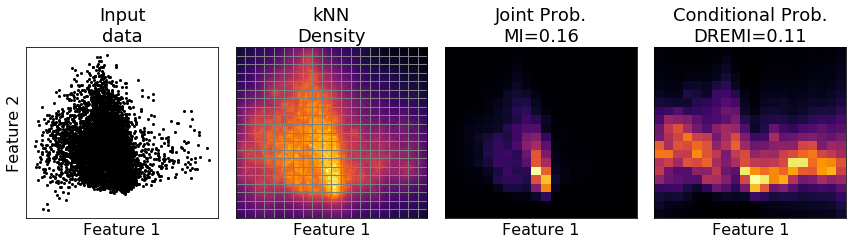

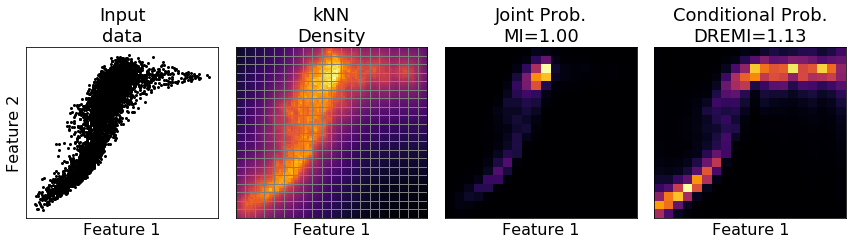

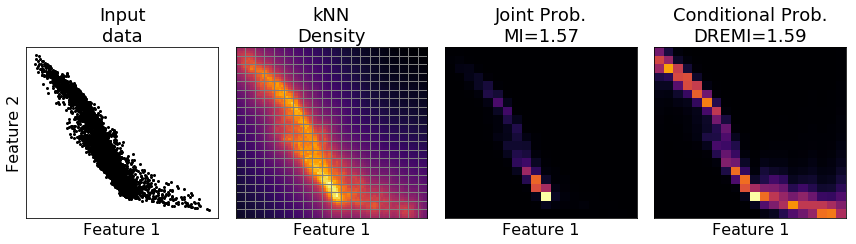

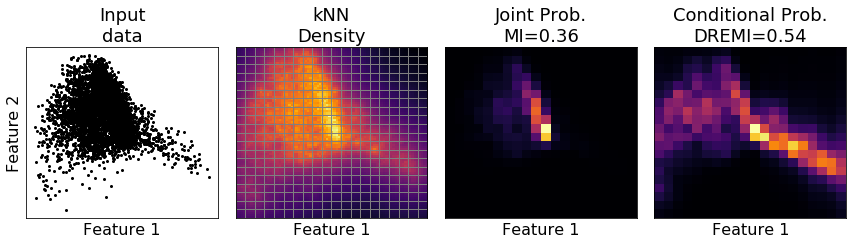

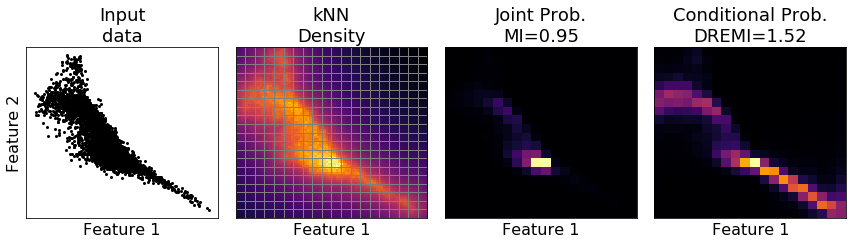

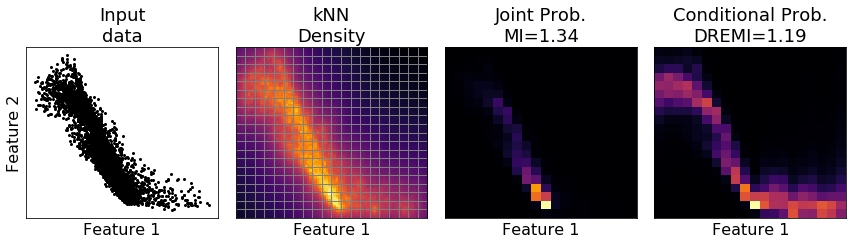

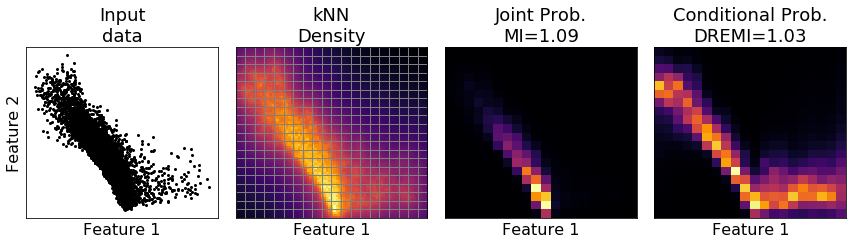

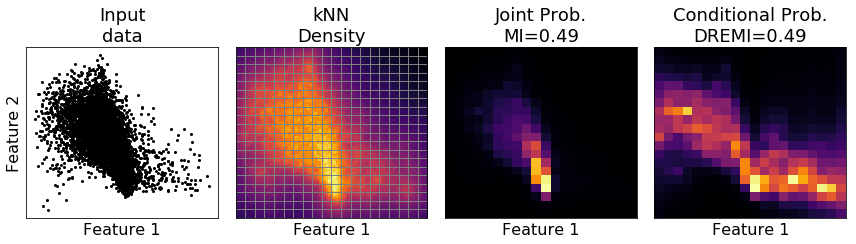

In [87]:
#fig, ax = plt.subplots(1)

for cl in np.unique(clusters):
    mask = clusters == cl
    
    mean = data_magic.iloc[:, top_genes[:10000]].loc[:, mask].mean(axis=1)
    
    scprep.stats.knnDREMI(data_magic['VIM'], mean, plot=True)
    

1.1607644626097073

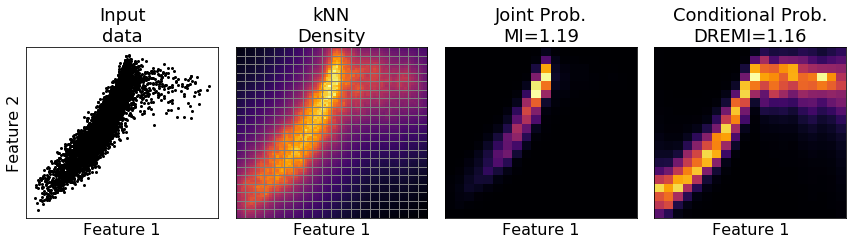

In [88]:
scprep.stats.knnDREMI(data_magic['VIM'], data_magic['MYC'], plot=True)


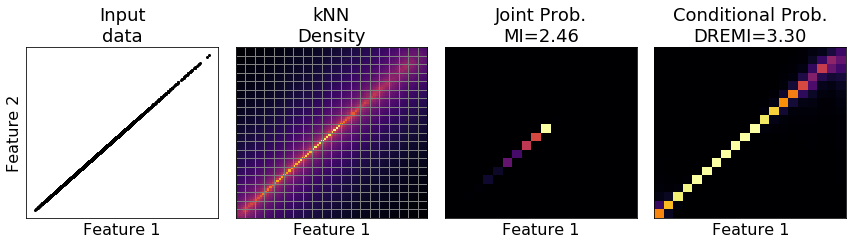

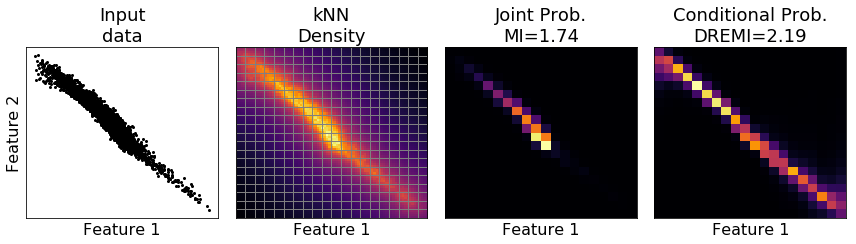

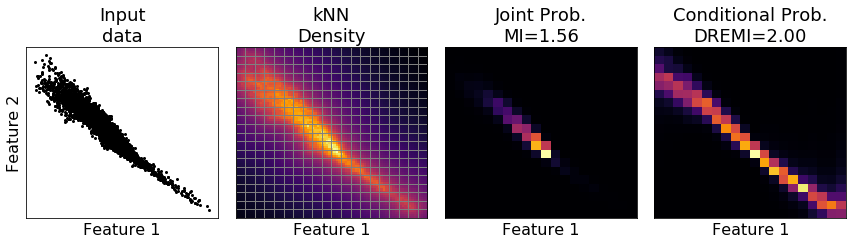

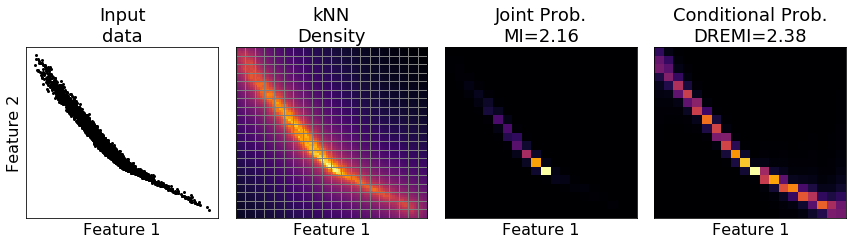

In [43]:
for ix in top_genes[:4]:
    scprep.stats.knnDREMI(data_magic['VIM'], data_magic.iloc[:,ix], plot=True)

In [4]:
data = pd.read_csv(data_path, index_col=0)

metadata = pd.read_csv(metadata_path, index_col=0)
metadata.columns = pd.Index(['annotated_clusters'])

#### Run PHATE

In [5]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 392 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.22 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.34 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 1.82 seconds.
Calculated PHATE in 2.21 seconds.


## Running Slingshot

Here we're just going to run the minimal code to run Slingshot with four clusters. For a more in depth tutorial, please see the TrajectoryInference series.



#### Generate Clusters

In [9]:
clusters = phate.cluster.kmeans(phate_op, n_clusters=5)
metadata['cluster'] = clusters

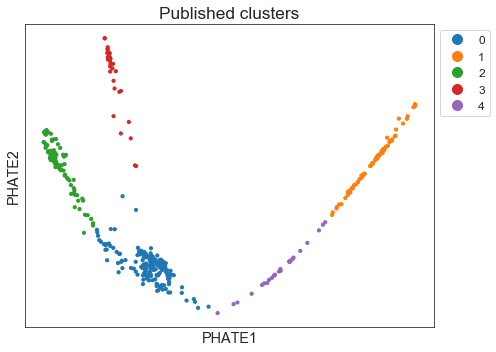

In [13]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['cluster'],
                 label_prefix='PHATE', ticks=None,
                 title='Published clusters', legend_anchor=(1,1),
                 figsize=(7,5))

#### Run Slingshot

In [10]:
results = scprep.run.Slingshot(data_phate, metadata['cluster'])

R[write to console]: Using full covariance matrix


#### Grab output from `results` dictionary

In [11]:
results.keys()

dict_keys(['pseudotime', 'curves', 'branch'])

In [12]:
pseudotime = results['pseudotime']
metadata['slingshot1'] = pseudotime.iloc[:,0]
metadata['slingshot2'] = pseudotime.iloc[:,1]

metadata['slingshot_branch'] = results['branch']

#### Plotting the principal curves and branch pseudotimes


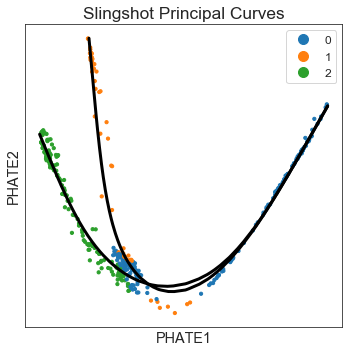

In [14]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['slingshot_branch'],
                 label_prefix='PHATE', ticks=None,
                 title='Slingshot Principal Curves',
                 figsize=(5,5))

# `results['curves']` returns as tensor (an array of arrays)
# Each array contains coordinates for the curves in the dimensionality reduced space
for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k', linewidth=3)

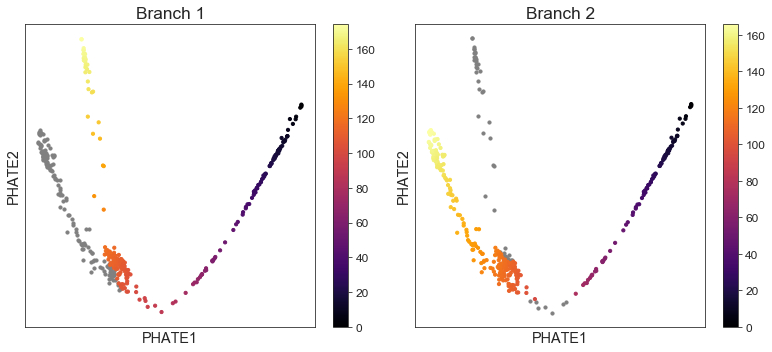

In [15]:
fig, axes = plt.subplots(1,2, figsize=(11,5))

for i, ax in enumerate(axes):
    curr_pseudotime = metadata['slingshot{}'.format(i+1)]
    m = ~pd.isnull(curr_pseudotime)
    # plot null points as grey
    scprep.plot.scatter2d(data_phate[~m], color='grey', s=10,
                          ax=ax)    
    # plot points on branch
    scprep.plot.scatter2d(data_phate[m], c=curr_pseudotime[m], s=10,
                         label_prefix='PHATE', ticks=None,
                          title='Branch {}'.format(i + 1),
                          ax=ax)
    
fig.tight_layout()

## Identifying branch-specific changes in gene expression

#### Genes that differentiate branch 1 from branch 2

In [20]:
# Create masks for each of the branches

# These two branches are mutually exclusive
branch0 = results['branch'] == 0
branch1 = results['branch'] == 1 
branch2 = results['branch'] == 2

In [23]:
results['pseudotime']

,0,1
1_iN1_C01,109.669410,109.485016
1_iN1_C02,106.167967,105.024507
1_iN1_C03,111.268054,NaN
1_iN1_C04,59.596186,59.508459
1_iN1_C05,68.482865,68.198405
...,...,...
714_507_1g_22d1_C60,NaN,163.593289
714_508_1g_22d1_C72,NaN,157.387796
715_506_1gg_22d2_C72,NaN,158.461076
715_507_1gg_22d2_C76,NaN,156.937530


In [25]:
dremi_branch0 = np.zeros(data.shape[1])
dremi_branch1 = np.zeros(data.shape[1])
dremi_branch2 = np.zeros(data.shape[1])

data_branch0 = data.loc[branch0]
data_branch1 = data.loc[branch1]
data_branch2 = data.loc[branch2]

pseudotime_branch0 = results['pseudotime'].loc[branch0].mean(axis=1)
pseudotime_branch1 = results['pseudotime'].loc[branch1][0]
pseudotime_branch2 = results['pseudotime'].loc[branch2][1]

for i, gene in enumerate(data):
    dremi_branch0[i] = scprep.stats.knnDREMI(pseudotime_branch0, data_branch0[gene])
    dremi_branch1[i] = scprep.stats.knnDREMI(pseudotime_branch1, data_branch1[gene])
    dremi_branch2[i] = scprep.stats.knnDREMI(pseudotime_branch2, data_branch2[gene])

/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)


In [26]:
diff = dremi_branch1 - dremi_branch2

In [28]:
branch0_genes = data.columns[np.argsort(dremi_branch0)[::-1][:30]]
branch1_genes = data.columns[np.argsort(diff)[::-1][:10]]
branch2_genes = data.columns[np.argsort(diff)[:10]]

interesting_genes = np.concatenate([branch0_genes, branch1_genes, branch2_genes])

In [30]:
pseudotime_order = np.zeros(data.shape[0], dtype=int)
raw_indices = np.arange(data.shape[0], dtype=int)

block_masks = [branch0, (branch1 & ~branch2), (branch2 & ~branch1)]

block_start = 0
for block_mask in block_masks:
    block_len = np.sum(block_mask)
    block_end = block_start + block_len
    pseudotime_order[block_start:block_end] = raw_indices[block_mask][np.argsort(results['pseudotime'].loc[block_mask].sum(axis=1))]
    block_start = block_end



In [39]:
results['pseudotime'].max()

0    174.060993
1    165.663879
dtype: float64

In [33]:
uniq_clusters = np.unique(clusters)
cmap = {cl:plt.cm.Set1(np.arange(len(uniq_clusters)))[i] for i, cl in enumerate(uniq_clusters)}

In [45]:
mkdir ../img

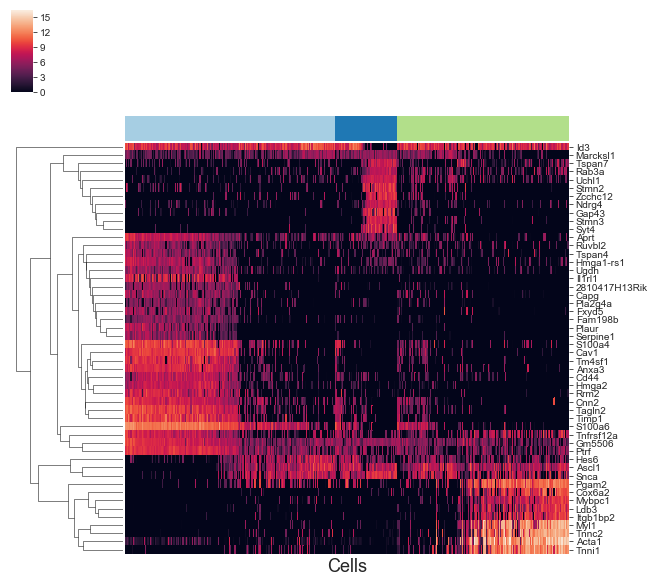

In [51]:
branch_assignment = np.zeros(data.shape[0], dtype=object)

branch_cmap = {0:'#a6cee3', 1:'#1f78b4', 2:'#b2df8a'}

    
col_colors = np.array([branch_cmap[b] for b in results['branch']])

cg = sns.clustermap(data.iloc[pseudotime_order][interesting_genes].T, 
               col_colors=col_colors[pseudotime_order], col_cluster=False,
                   yticklabels=data.iloc[pseudotime_order][interesting_genes].T.index,
                   xticklabels=[])
cg.ax_heatmap.set_xlabel('Cells', fontsize=18)

cg.fig.set_size_inches(10,10)

cg.savefig('../img/branch_specific_genes.png', dpi=300)